## Regression Analysis SDG Index vs GDP Per Capita

In [1]:
library(readr)
library(ggplot2)
library(dplyr)
library(tidyverse)

Warning message:
“package ‘readr’ was built under R version 4.0.2”
Warning message:
“package ‘ggplot2’ was built under R version 4.0.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘tidyverse’ was built under R version 4.0.1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.1     ✔ stringr 1.4.0
✔ tidyr   1.1.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### Cleaning the Data

In [2]:
# Classication of countries based on high income countries and rest of the world. Classification based on 
# https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups

classification <- read.csv('high_income_classification.csv')
high_income_countries <- classification %>% filter(GroupCode == 'HIC') %>% rename(ID = CountryCode)
# high_income_countries
# nrow(high_income_countries)
rest_of_world_countries <- classification %>% filter(GroupCode == 'LIC' | GroupCode == 'LMY' | GroupCode == 'LMC' | GroupCode == 'MIC' | GroupCode == 'UMC') %>% rename(ID = CountryCode) %>% distinct(CountryName, .keep_all = TRUE)# remove duplicated data
# head(rest_of_world_countries)
# nrow(rest_of_world_countries)
# rest_of_world_countries

In [3]:
# SDG Index Data from Years 2016 - 2019 sourced from SDG Website 
SDG_Index_2016 <- read.csv('2016GlobalIndexResults(1).csv')
SDG_Index_2017 <- read.csv('2017GlobalIndexResults(1).csv')
SDG_Index_2018 <- read.csv('2018GlobalIndexResults(1).csv')
SDG_Index_2019 <- read.csv('2019GlobalIndexResults-1.csv')

In [4]:
SDGI_2016 <- SDG_Index_2016 %>% select(ID, SDGI_Score, SDGI_Rank) %>% rename(SDGI_2016 = 	SDGI_Score, SDGI_Rank_2016 = SDGI_Rank)
# head(SDGI_2016)
SDGI_2017 <- SDG_Index_2017 %>% select(ISO3	, Global.Index.Score..0.100., Global.Index.Rank) %>% 
rename(ID = ISO3, SDGI_2017 = Global.Index.Score..0.100., SDGI_Rank_2017 = Global.Index.Rank)
# head(SDGI_2017)
SDGI_2018 <- SDG_Index_2018 %>% select(X	, X.1, X.2) %>% rename(ID = X, SDGI_2018 = X.1, SDGI_Rank_2018 = X.2)
# head(SDGI_2018)
SDGI_2019 <- SDG_Index_2019 %>% select(	X, X.1, X.2) %>% rename(ID = X, SDGI_2019 = X.1, SDGI_Rank_2019 = X.2)
# head(SDGI_2019)

### Final Data Frame 

In [5]:
# Combined Data frame with country classificaiton and SDG Index 
test_merge <- merge(SDGI_2016, SDGI_2017)
merge_2 <- merge(test_merge, SDGI_2018)
merge_3 <- merge(merge_2, SDGI_2019)
country_classification <- merge(x = high_income_countries, y = rest_of_world_countries, all = TRUE)
merge_4 <- merge(merge_3, country_classification)
df <- merge_4 %>% arrange(desc(SDGI_2016)) %>% relocate(CountryName, GroupName)


# GDP Data - Data sourced from worldbank 
GDP_per_capita <- read.csv('GDP_per_capita_worldbank.csv')
GDP_per_capita <- GDP_per_capita %>% select(World.Development.Indicators	, 	X.58, X.59, X.60, X.61) %>% 
rename(ID = World.Development.Indicators, gdp_2016 = X.58, gdp_2017 = X.59, gdp_2018 = X.60, gdp_2019 = X.61)

# C02 Emissions Data per capita sourced from worldbank
CO2_per_capita <- read.csv('emissions.csv')
CO2_per_capita <- CO2_per_capita %>% select(Country.Name, Country.Code, 	X2016) %>% 
rename(ID = Country.Code, emissions_per_capita_2016_metric_tons =  	X2016)

df <- merge(df, GDP_per_capita)
df <- merge(df, CO2_per_capita)
df <- na.omit(df)
nrow(df)
df <- df %>% arrange(desc(gdp_2016)) %>% relocate(CountryName, GroupName, gdp_2016, gdp_2017, gdp_2018, gdp_2019)
df$GroupName <- ifelse(df$GroupName == "High income", 0, 1)
# head(df)

df_2016 <- df %>% select(	CountryName, GroupName, gdp_2016, SDGI_2016, SDGI_Rank_2016, emissions_per_capita_2016_metric_tons)
head(df_2016)

# Group Name 1 if High Income, 0 otherwise 
model_2019 <- df %>% select(CountryName, ID, gdp_2019, SDGI_2019, SDGI_Rank_2019, GroupName)
regression_model <- lm(SDGI_2019 ~ gdp_2019 + GroupName, data = model_2019)


[1] 141

,CountryName,GroupName,gdp_2016,SDGI_2016,SDGI_Rank_2016,emissions_per_capita_2016_metric_tons
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,Luxembourg,0,104278.39,76.66,16,15.442613
2,Switzerland,0,80172.23,80.87,5,4.117490
3,Norway,0,70459.18,82.31,3,7.836962
4,Ireland,0,63197.08,76.75,14,7.930341
5,Iceland,0,61466.80,78.41,9,6.154684
6,United States,0,57927.52,72.71,25,15.502204


### Regression Model with Dummy Variable 

In [6]:
# Regression model with one independent variable and one dummy variable
# Group Name 0 if High Income, 1 otherwise 
model_2019 <- df %>% select(CountryName, ID, gdp_2019, SDGI_2019, SDGI_Rank_2019, GroupName)
regression_model <- lm(SDGI_2019 ~ gdp_2019 + GroupName, data = model_2019)
summary(regression_model)


Call:
lm(formula = SDGI_2019 ~ gdp_2019 + GroupName, data = model_2019)

Residuals:
    Min      1Q  Median      3Q     Max 
-22.198  -5.853   2.252   6.244  15.206 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.988e+01  2.229e+00  31.345  < 2e-16 ***
gdp_2019     1.447e-04  4.951e-05   2.922 0.004069 ** 
GroupName   -8.648e+00  2.213e+00  -3.907 0.000146 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.769 on 138 degrees of freedom
Multiple R-squared:  0.4308,	Adjusted R-squared:  0.4226 
F-statistic: 52.23 on 2 and 138 DF,  p-value: < 2.2e-16


### Regression Model for High Income Countries 

In [7]:
# Separate Regression Models for High Income Countries and Rest of the World 
# High Income Countries Regression Model 
model_2019_high_income <- model_2019 %>% filter(GroupName == 0)
high_income_regression <- lm(SDGI_2019 ~ gdp_2019, data = model_2019_high_income)
summary(high_income_regression)


Call:
lm(formula = SDGI_2019 ~ gdp_2019, data = model_2019_high_income)

Residuals:
    Min      1Q  Median      3Q     Max 
-11.504  -3.941   1.850   3.589   8.627 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7.276e+01  1.556e+00  46.760   <2e-16 ***
gdp_2019    6.994e-05  3.474e-05   2.013   0.0502 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.345 on 44 degrees of freedom
Multiple R-squared:  0.08435,	Adjusted R-squared:  0.06354 
F-statistic: 4.054 on 1 and 44 DF,  p-value: 0.05022


### Regression Model for Rest of The World 

In [8]:
# Rest of the World Regression Model 
model_2019_rest_of_the_world <- model_2019 %>% filter(GroupName == 1)
rest_of_world_regression <- lm(SDGI_2019 ~ gdp_2019, data = model_2019_rest_of_the_world)
summary(rest_of_world_regression)


Call:
lm(formula = SDGI_2019 ~ gdp_2019, data = model_2019_rest_of_the_world)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.7171  -4.1859  -0.7855   4.2415  15.0849 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.387e+01  1.023e+00  52.647  < 2e-16 ***
gdp_2019    2.018e-03  2.032e-04   9.932 2.85e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.244 on 93 degrees of freedom
Multiple R-squared:  0.5147,	Adjusted R-squared:  0.5095 
F-statistic: 98.64 on 1 and 93 DF,  p-value: 2.854e-16


## 2016 Regression Model with C02 Emissions and GDP_Per_capita

[1] 141


Call:
lm(formula = SDGI_2016 ~ poly(gdp_2016, 3) + poly(emissions_per_capita_2016_metric_tons, 
    3), data = df_2016)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.5416  -4.1500  -0.0812   4.0061  15.6211 

Coefficients:
                                                Estimate Std. Error t value
(Intercept)                                      58.4448     0.5026 116.285
poly(gdp_2016, 3)1                               79.7559     9.5432   8.357
poly(gdp_2016, 3)2                              -35.4054     7.3832  -4.795
poly(gdp_2016, 3)3                               26.8063     7.1031   3.774
poly(emissions_per_capita_2016_metric_tons, 3)1  16.3442     9.4557   1.729
poly(emissions_per_capita_2016_metric_tons, 3)2 -49.0011     8.0265  -6.105
poly(emissions_per_capita_2016_metric_tons, 3)3  53.8599     6.4964   8.291
                                                Pr(>|t|)    
(Intercept)                                      < 2e-16 ***
poly(gdp_2016, 3)1            

ERROR: Error in plot_ly(data = df_2016, z = ~poly(gdp_2016, 3), x = ~poly(emissions_per_capita_2016_metric_tons, : could not find function "plot_ly"


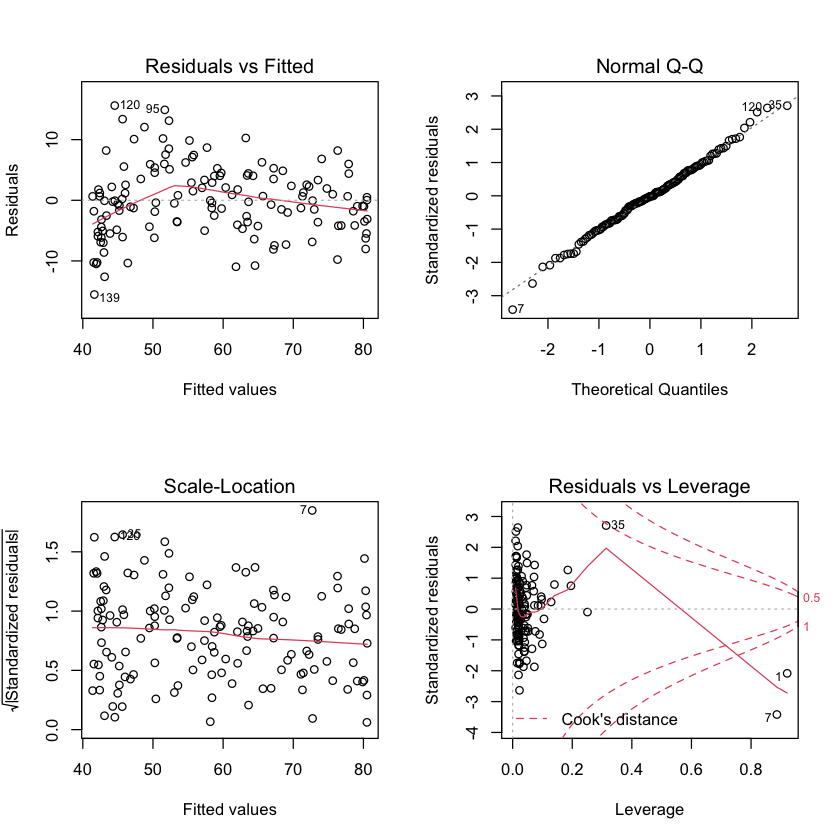

In [9]:
# head(df_2016)
nrow(df_2016)
# GDP per capita to the polynomial order of 3, emissions per capita to the polynomial order of 3
regression_2016 <- lm(SDGI_2016 ~ poly(gdp_2016, 3) + poly(emissions_per_capita_2016_metric_tons, 3), data = df_2016)
summary(regression_2016)
par(mfrow = c(2, 2))
plot(regression_2016)
# df_2016[35,]
df_2016_modified <- df_2016[-c(1, 7, 24, 35),]
# df_2016_modified 

plot_ly(data = df_2016, z = ~poly(gdp_2016, 3), x = ~poly(emissions_per_capita_2016_metric_tons, 3), y = ~SDGI_2016, opacity = 0.5) %>%
  add_markers()

## Regression GDP per capita v Emissions per Capita of Polynomial Order 3

In [ ]:
emissions_per_capita <- lm(emissions_per_capita_2016_metric_tons ~ poly(gdp_2016,3), data = df_2016)
summary(emissions_per_capita)

par(mfrow = c(2, 2))
plot(emissions_per_capita)

# Regression with omited rows 
# modified_emissions_per_capita <- lm(emissions_per_capita_2016_metric_tons ~ poly(gdp_2016,3), data = df_2016_modified)
# summary(modified_emissions_per_capita)

# par(mfrow = c(2, 2))
# plot(modified_emissions_per_capita)

## Regression GDP Per Capita v Emissions Per Capita of Polynomial Order 2

In [ ]:
emissions_per_capita_2 <- lm(emissions_per_capita_2016_metric_tons ~ poly(gdp_2016,2), data = df_2016)
summary(emissions_per_capita_2)

par(mfrow = c(2, 2))
plot(emissions_per_capita_2)

## Linear Regression GDP Per Capita v Emissions Per Capita 

In [ ]:
emissions_per_capita_linear <- lm(emissions_per_capita_2016_metric_tons ~ poly(gdp_2016,2), data = df_2016)
summary(emissions_per_capita_linear)

par(mfrow = c(2, 2))
plot(emissions_per_capita_linear)

## Polynomial Regression 2D Visualization

In [ ]:
# 3rd Order Polynomial Regression
qplot(gdp_2016, emissions_per_capita_2016_metric_tons, data = df_2016, 
      geom=c('point', 'smooth'), method = 'lm', formula = y ~ poly(x, 3))
# 2nd Order Polynomial Regression
qplot(gdp_2016, emissions_per_capita_2016_metric_tons, data = df_2016, 
      geom=c('point', 'smooth'), method = 'lm', formula = y ~ poly(x, 2))
# Linear Regression 
qplot(gdp_2016, emissions_per_capita_2016_metric_tons, data = df_2016, 
      geom=c('point', 'smooth'), method = 'lm')